step   200 | train_mean 4.3001 | greedy_mean 4.2173 | baseline 4.2768 | loss -0.2785 | 199.5s
step   400 | train_mean 4.1051 | greedy_mean 4.1409 | baseline 4.1519 | loss 0.0507 | 413.4s
step   600 | train_mean 4.1287 | greedy_mean 4.1116 | baseline 4.1322 | loss -0.0148 | 625.3s
step   800 | train_mean 4.1563 | greedy_mean 4.1247 | baseline 4.1404 | loss -0.0690 | 837.4s
step  1000 | train_mean 4.1445 | greedy_mean 4.1074 | baseline 4.1153 | loss -0.1216 | 1063.2s
step  1200 | train_mean 4.1106 | greedy_mean 4.1193 | baseline 4.1252 | loss -0.0496 | 1275.7s
step  1400 | train_mean 4.1043 | greedy_mean 4.0890 | baseline 4.1048 | loss -0.0492 | 1490.3s
step  1600 | train_mean 4.1096 | greedy_mean 4.1175 | baseline 4.1126 | loss -0.0707 | 1708.4s
step  1800 | train_mean 4.0764 | greedy_mean 4.0662 | baseline 4.0955 | loss -0.0414 | 1918.4s
step  2000 | train_mean 4.0439 | greedy_mean 4.0696 | baseline 4.0794 | loss -0.0143 | 2131.8s
step  2200 | train_mean 4.0871 | greedy_mean 4.0729 | b

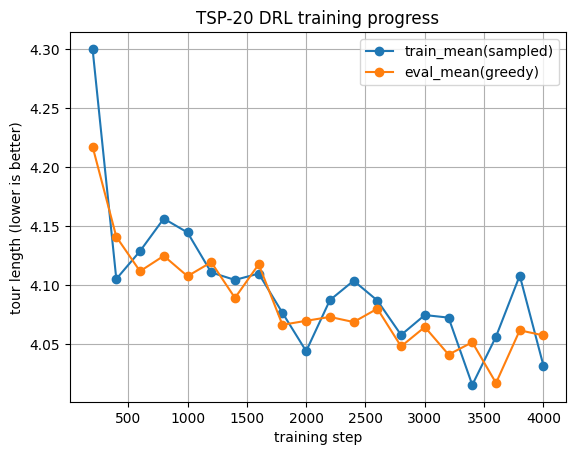

coords: [[0.9755991  0.5138286 ]
 [0.9699024  0.36079663]
 [0.6687073  0.23106426]
 [0.73278266 0.8510801 ]
 [0.5727143  0.4401905 ]
 [0.04589146 0.49850315]
 [0.6806613  0.77908635]
 [0.11641258 0.3713045 ]
 [0.02924722 0.11504579]
 [0.24943858 0.5467358 ]
 [0.2912051  0.00533378]
 [0.6990422  0.7296103 ]
 [0.8358     0.73186666]
 [0.40377223 0.36178505]
 [0.18856591 0.14190519]
 [0.73082775 0.81722295]
 [0.31776708 0.26787376]
 [0.2696858  0.23543954]
 [0.87507325 0.6638038 ]
 [0.37006962 0.94750875]]
tour  : [10 14  8 17 16 13  7  5  9 19  6  3 15 11 12 18  0  1  2  4]
len   : 4.041751384735107


In [1]:
# drl_tsp_reinforce_pytorch_plot.py
# Minimal DRL TSP (Euclidean) with Transformer encoder + autoregressive selection (REINFORCE)
# pip install torch matplotlib

import time
import random
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt


# -----------------------------
# Utilities
# -----------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def tour_length(coords: torch.Tensor, tour: torch.Tensor) -> torch.Tensor:
    """
    coords: [B, N, 2]
    tour:   [B, N]  (permutation indices)
    returns: [B] length
    """
    B, N, _ = coords.shape
    idx = tour.unsqueeze(-1).expand(B, N, 2)
    ordered = coords.gather(1, idx)  # [B, N, 2]
    rolled = torch.roll(ordered, shifts=-1, dims=1)
    seg = (ordered - rolled).pow(2).sum(-1).sqrt()  # [B, N]
    return seg.sum(-1)  # [B]

def masked_softmax(logits: torch.Tensor, mask: torch.Tensor, dim: int = -1) -> torch.Tensor:
    masked_logits = logits.masked_fill(~mask, -1e9)
    return F.softmax(masked_logits, dim=dim)

def sample_from_probs(probs: torch.Tensor) -> torch.Tensor:
    return torch.multinomial(probs, num_samples=1).squeeze(1)

def greedy_from_probs(probs: torch.Tensor) -> torch.Tensor:
    return probs.argmax(dim=-1)


# -----------------------------
# Model
# -----------------------------
class TSPPolicy(nn.Module):
    def __init__(self, d_model=128, n_heads=8, n_layers=3, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Linear(2, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=4*d_model,
            dropout=dropout, batch_first=True, activation="relu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)

        self.start = nn.Parameter(torch.randn(d_model))
        self.log_temp = nn.Parameter(torch.tensor(0.0))

    def forward(self, coords: torch.Tensor, sample: bool = True):
        B, N, _ = coords.shape
        x = self.embed(coords)         # [B, N, D]
        h = self.encoder(x)            # [B, N, D]

        K = self.k_proj(h)             # [B, N, D]
        avail = torch.ones(B, N, dtype=torch.bool, device=coords.device)

        tour = []
        logps = []

        q = self.start.unsqueeze(0).expand(B, self.d_model)  # [B, D]

        for _ in range(N):
            Q = self.q_proj(q).unsqueeze(1)                  # [B, 1, D]
            logits = torch.bmm(Q, K.transpose(1, 2)).squeeze(1)  # [B, N]

            temp = torch.exp(self.log_temp).clamp(0.1, 10.0)
            logits = logits / temp

            probs = masked_softmax(logits, avail, dim=-1)

            if sample:
                a = sample_from_probs(probs)
            else:
                a = greedy_from_probs(probs)

            lp = torch.log(probs.gather(1, a.unsqueeze(1)).squeeze(1) + 1e-12)

            tour.append(a)
            logps.append(lp)

            avail.scatter_(1, a.unsqueeze(1), False)
            q = h.gather(1, a.view(B, 1, 1).expand(B, 1, self.d_model)).squeeze(1)

        tour = torch.stack(tour, dim=1)          # [B, N]
        logp = torch.stack(logps, dim=1).sum(1)  # [B]
        return tour, logp


# -----------------------------
# Training
# -----------------------------
@dataclass
class TrainConfig:
    n_nodes: int = 20
    batch_size: int = 256
    steps: int = 4000
    lr: float = 1e-4
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    print_every: int = 200
    seed: int = 42
    baseline_beta: float = 0.9


def train():
    cfg = TrainConfig()
    set_seed(cfg.seed)

    policy = TSPPolicy().to(cfg.device)
    opt = torch.optim.Adam(policy.parameters(), lr=cfg.lr)

    baseline = None
    t0 = time.time()

    # --- history for plotting ---
    history_steps = []
    history_train_mean = []
    history_greedy_mean = []

    for step in range(1, cfg.steps + 1):
        coords = torch.rand(cfg.batch_size, cfg.n_nodes, 2, device=cfg.device)

        tour, logp = policy(coords, sample=True)
        L = tour_length(coords, tour)  # [B]

        with torch.no_grad():
            batch_mean = L.mean()
            if baseline is None:
                baseline = batch_mean
            else:
                baseline = cfg.baseline_beta * baseline + (1 - cfg.baseline_beta) * batch_mean

        adv = (L - baseline).detach()
        loss = (adv * logp).mean()

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
        opt.step()

        if step % cfg.print_every == 0:
            with torch.no_grad():
                coords_val = torch.rand(1024, cfg.n_nodes, 2, device=cfg.device)
                tour_g, _ = policy(coords_val, sample=False)
                Lg = tour_length(coords_val, tour_g).mean().item()

            elapsed = time.time() - t0
            train_mean = L.mean().item()

            history_steps.append(step)
            history_train_mean.append(train_mean)
            history_greedy_mean.append(Lg)

            print(
                f"step {step:5d} | train_mean {train_mean:.4f} | greedy_mean {Lg:.4f} | "
                f"baseline {baseline.item():.4f} | loss {loss.item():.4f} | {elapsed:.1f}s"
            )

    # --- plot after training ---
    plt.figure()
    plt.plot(history_steps, history_train_mean, marker="o")
    plt.plot(history_steps, history_greedy_mean, marker="o")
    plt.xlabel("training step")
    plt.ylabel("tour length (lower is better)")
    plt.title("TSP-20 DRL training progress")
    plt.legend(["train_mean(sampled)", "eval_mean(greedy)"])
    plt.grid(True)
    plt.show()

    return policy, cfg


def demo(policy: TSPPolicy, n_nodes=20, device="cpu"):
    policy.eval()
    coords = torch.rand(1, n_nodes, 2, device=device)
    with torch.no_grad():
        tour, _ = policy(coords, sample=False)
        L = tour_length(coords, tour).item()
    print("coords:", coords.squeeze(0).cpu().numpy())
    print("tour  :", tour.squeeze(0).cpu().numpy())
    print("len   :", L)


if __name__ == "__main__":
    policy, cfg = train()
    demo(policy, n_nodes=cfg.n_nodes, device=cfg.device)
